In [1]:
import pandas as pd
file_path = '2025-VeloCityX-Expanded-Fan-Engagement-Data.csv' 
df = pd.read_csv(file_path)

# Display basic information about the data
print(df.info())

# Display the first few rows of the DataFrame to understand its structure
print(df.head())

# Check for any missing values in the data
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                                   Non-Null Count  Dtype 
---  ------                                   --------------  ----- 
 0   User ID                                  100 non-null    object
 1   Fan Challenges Completed                 100 non-null    int64 
 2   Predictive Accuracy (%)                  100 non-null    int64 
 3   Virtual Merchandise Purchases            100 non-null    int64 
 4   Sponsorship Interactions (Ad Clicks)     100 non-null    int64 
 5   Time on Live 360 (mins)                  100 non-null    int64 
 6   Real-Time Chat Activity (Messages Sent)  100 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 5.6+ KB
None
  User ID  Fan Challenges Completed  Predictive Accuracy (%)  \
0    U001                         5                       80   
1    U002                         8                       60   
2    U003                    

Check Virtual Merchandise Purchases columns

In [2]:
df['User ID'] = df['User ID'].str[1:].astype(int)
top_purchasers = df.sort_values(by='Virtual Merchandise Purchases', ascending=False)
print("Users most likely to purchase virtual merchandise:\n", top_purchasers[['User ID', 'Virtual Merchandise Purchases']])

Users most likely to purchase virtual merchandise:
     User ID  Virtual Merchandise Purchases
52       53                              6
35       36                              6
78       79                              6
60       61                              6
82       83                              6
..      ...                            ...
30       31                              0
28       29                              0
25       26                              0
61       62                              0
81       82                              0

[100 rows x 2 columns]


Check for putliers in the data set

In [3]:
import numpy as np
outliers_iqr = {}

for col in df.select_dtypes(include=np.number).columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers for the current column
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # Store results if there are outliers
    if not outliers.empty:
        outliers_iqr[col] = outliers[col]

# Display the outliers for all columns using the IQR method
for column, outliers in outliers_iqr.items():
    print(f"Outliers in column '{column}' using IQR method:")
    print(outliers)


convert Merchandise purchased into ordinal, 
Low: 0-1 purchases;
Medium: 2-3 purchases;
High: 4+ purchases;
Binning the 'Virtual Merchandise Purchases' column into 'Low', 'Medium', and 'High' categories

In [4]:
purchase_bins = [0, 1, 3, float('inf')]
purchase_labels = ['Low', 'Medium', 'High']
df['Purchase Category'] = pd.cut(df['Virtual Merchandise Purchases'], bins=purchase_bins, labels=purchase_labels, right=False)

print(df[['User ID', 'Virtual Merchandise Purchases', 'Purchase Category']])


    User ID  Virtual Merchandise Purchases Purchase Category
0         1                              3              High
1         2                              1            Medium
2         3                              0               Low
3         4                              2            Medium
4         5                              5              High
..      ...                            ...               ...
95       96                              6              High
96       97                              3              High
97       98                              1            Medium
98       99                              0               Low
99      100                              3              High

[100 rows x 3 columns]


Classification: Clustering

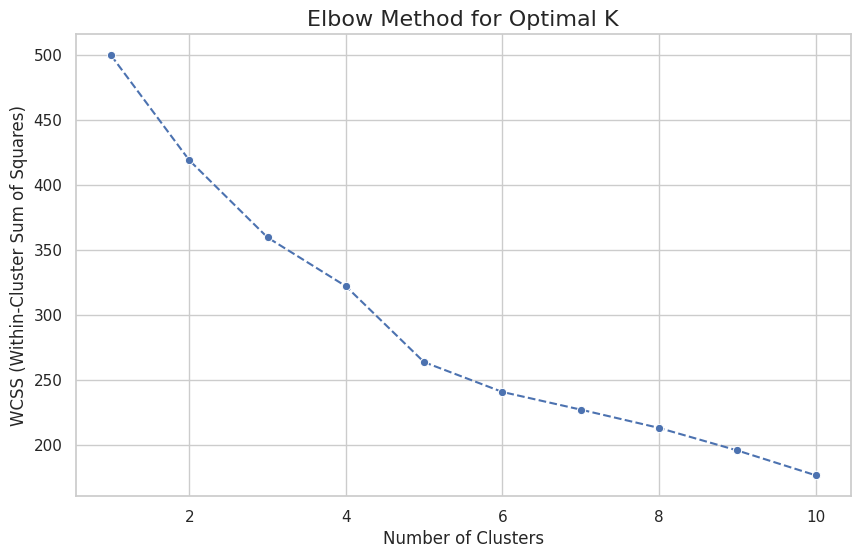

    User ID  Virtual Merchandise Purchases  Cluster
0         1                              3        2
1         2                              1        2
2         3                              0        2
3         4                              2        0
4         5                              5        2
..      ...                            ...      ...
95       96                              6        2
96       97                              3        1
97       98                              1        2
98       99                              0        1
99      100                              3        2

[100 rows x 3 columns]


In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


# Use all columns except 'User ID' and 'Virtual Merchandise Purchases' for clustering
X = df[['Fan Challenges Completed', 'Predictive Accuracy (%)', 
        'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 
        'Real-Time Chat Activity (Messages Sent)']]

# Step 1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 2: Compute WCSS for different values of K using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Step 3: Plot the elbow curve using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, 11), y=wcss, marker='o', linestyle='--', color='b')
plt.title('Elbow Method for Optimal K', fontsize=16)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
plt.grid(True)
plt.show()

# After visually identifying the elbow point from the plot, fit the KMeans model using the optimal number of clusters
optimal_k = 3  # Adjust the number of clusters based on your elbow plot observation
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Display the data with cluster assignments
print(df[['User ID', 'Virtual Merchandise Purchases', 'Cluster']])


In [6]:
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print(df[['User ID', 'Virtual Merchandise Purchases', 'Cluster']])


    User ID  Virtual Merchandise Purchases  Cluster
0         1                              3        2
1         2                              1        1
2         3                              0        3
3         4                              2        1
4         5                              5        3
..      ...                            ...      ...
95       96                              6        0
96       97                              3        3
97       98                              1        2
98       99                              0        0
99      100                              3        2

[100 rows x 3 columns]


/usr/local/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [7]:
mean_purchases_per_cluster = df.groupby('Cluster')['Virtual Merchandise Purchases'].mean()
print("Mean Merchandise Purchases per Cluster:")
print(mean_purchases_per_cluster)

# Get the value counts of each cluster to understand their sizes
cluster_value_counts = df['Cluster'].value_counts()
print("\nValue Counts of Each Cluster:")
print(cluster_value_counts)

purchase_category_counts_per_cluster = df.groupby('Cluster')['Purchase Category'].value_counts().unstack()
print("Value Counts of Purchase Category in Each Cluster:")
print(purchase_category_counts_per_cluster)

Mean Merchandise Purchases per Cluster:
Cluster
0    3.538462
1    2.538462
2    2.360000
3    2.173913
Name: Virtual Merchandise Purchases, dtype: float64

Value Counts of Each Cluster:
Cluster
1    26
0    26
2    25
3    23
Name: count, dtype: int64
Value Counts of Purchase Category in Each Cluster:
Purchase Category  Low  Medium  High
Cluster                             
0                    4       4    18
1                    4      11    11
2                    5       9    11
3                    7       7     9


Based on my results, it does appear that the clustering doesn't show a clear separation between the categories of merchandise purchases (Low, Medium, High) since the means and distribution of each category across clusters are quite similar. 

Next, trying classification using Decision Trees

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Prepare the features (X) and target (y)
X = df.drop(columns=['User ID', 'Virtual Merchandise Purchases', 'Purchase Category', 'Cluster'])  # Features
y = df['Purchase Category']  # Target variable

# Step 2: Encode the target variable (Purchase Category) if necessary
y = y.astype('category').cat.codes  # Converts Low, Medium, High into numerical codes

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Train the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = decision_tree.predict(X_test)

# Step 6: Evaluate the model's performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.43333333333333335

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40         5
           1       0.30      0.33      0.32         9
           2       0.53      0.50      0.52        16

    accuracy                           0.43        30
   macro avg       0.41      0.41      0.41        30
weighted avg       0.44      0.43      0.44        30



Accuracy is only 0.43. Next, trying is cross-validation improves the model

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, accuracy_score

y_pred_cv = cross_val_predict(decision_tree, X, y, cv=5)

# Calculate accuracy
accuracy_cv = accuracy_score(y, y_pred_cv)
print("Cross-Validated Accuracy:", accuracy_cv)

# Display the classification report for cross-validated predictions
print("\nCross-Validated Classification Report:\n", classification_report(y, y_pred_cv))

Cross-Validated Accuracy: 0.28

Cross-Validated Classification Report:
               precision    recall  f1-score   support

           0       0.07      0.05      0.06        20
           1       0.18      0.23      0.20        31
           2       0.43      0.41      0.42        49

    accuracy                           0.28       100
   macro avg       0.23      0.23      0.23       100
weighted avg       0.28      0.28      0.28       100



The accuracy went down. Discard Model

Next, trying classification using Naive Bayes

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X = df[['Fan Challenges Completed', 'Predictive Accuracy (%)', 
          'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 
          'Real-Time Chat Activity (Messages Sent)']]
y = df['Purchase Category']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = GaussianNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))



Accuracy: 0.4666666666666667

Classification Report:
               precision    recall  f1-score   support

        High       0.58      0.69      0.63        16
         Low       0.00      0.00      0.00         5
      Medium       0.38      0.33      0.35         9

    accuracy                           0.47        30
   macro avg       0.32      0.34      0.33        30
weighted avg       0.42      0.47      0.44        30


Confusion Matrix:
 [[11  2  3]
 [ 3  0  2]
 [ 5  1  3]]


Accuracy is only 0.43

Next, trying classification using Logistic regression ( check is sale is >= 2 or < 2)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(df.isnull().sum())

df = df.dropna()

df['Purchases_Binary'] = (df['Virtual Merchandise Purchases'] >= 2).astype(int)

X = df.drop(columns=['User ID', 'Virtual Merchandise Purchases', 'Purchases_Binary','Purchase Category'])  # Features
y = df['Purchases_Binary']  

# Check the shape of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Fit the model
logistic_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)


User ID                                    0
Fan Challenges Completed                   0
Predictive Accuracy (%)                    0
Virtual Merchandise Purchases              0
Sponsorship Interactions (Ad Clicks)       0
Time on Live 360 (mins)                    0
Real-Time Chat Activity (Messages Sent)    0
Purchase Category                          0
Cluster                                    0
dtype: int64
Shape of X: (100, 6)
Shape of y: (100,)
Accuracy: 0.7000
Confusion Matrix:
[[ 2  5]
 [ 1 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.71      0.92      0.80        13

    accuracy                           0.70        20
   macro avg       0.69      0.60      0.60        20
weighted avg       0.69      0.70      0.66        20



Accuracy 60% ( highest untill now)

Next, trying linear regression

Mean Absolute Error (MAE): 1.7429054692583397
Mean Squared Error (MSE): 4.032191921666091
Root Mean Squared Error (RMSE): 2.008031852751866
R-squared (R2) Score: -0.044008265103418376


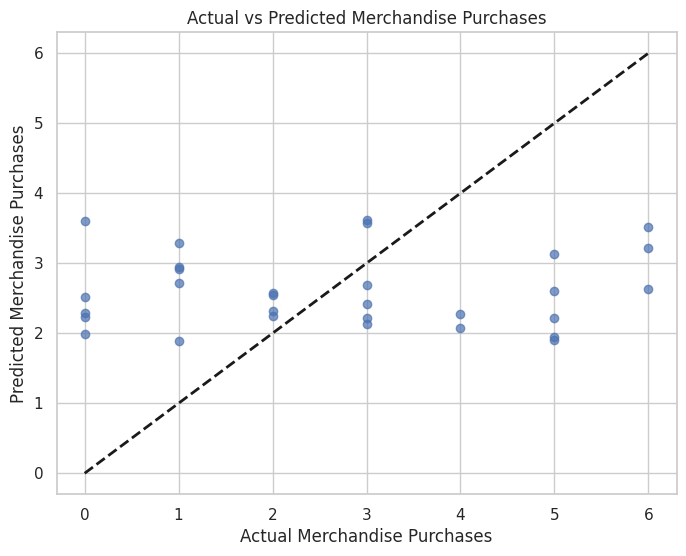

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

data = pd.read_csv('2025-VeloCityX-Expanded-Fan-Engagement-Data.csv')  

X = data[['Fan Challenges Completed', 'Predictive Accuracy (%)', 
          'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 
          'Real-Time Chat Activity (Messages Sent)']]

y = data['Virtual Merchandise Purchases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2) Score: {r2}')

# Plot the true vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', linewidth=2)
plt.xlabel('Actual Merchandise Purchases')
plt.ylabel('Predicted Merchandise Purchases')
plt.title('Actual vs Predicted Merchandise Purchases')
plt.show()


This negative value is a sign that the model is not performing well. An R-squared value of -0.04 suggests that the model is performing worse than a simple horizontal line (mean) model. In other words, the linear regression model is not effectively capturing the relationship between the features and the target variable.

Next, trying regression using Random Forest and Gradient Boosing

In [13]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = data[['Fan Challenges Completed', 'Predictive Accuracy (%)', 
          'Sponsorship Interactions (Ad Clicks)', 'Time on Live 360 (mins)', 
          'Real-Time Chat Activity (Messages Sent)']]
y = data['Virtual Merchandise Purchases']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)

print("Random Forest Regressor:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, rf_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, rf_pred))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, rf_pred, squared=False))
print("R-squared (R2) Score:", r2_score(y_test, rf_pred))

print("\nGradient Boosting Regressor:")
print("Mean Absolute Error (MAE):", mean_absolute_error(y_test, gb_pred))
print("Mean Squared Error (MSE):", mean_squared_error(y_test, gb_pred))
print("Root Mean Squared Error (RMSE):", mean_squared_error(y_test, gb_pred, squared=False))
print("R-squared (R2) Score:", r2_score(y_test, gb_pred))


Random Forest Regressor:
Mean Absolute Error (MAE): 1.9386666666666668
Mean Squared Error (MSE): 4.713653333333334
Root Mean Squared Error (RMSE): 2.1710949618414515
R-squared (R2) Score: -0.2204510932105872

Gradient Boosting Regressor:
Mean Absolute Error (MAE): 2.360646072937365
Mean Squared Error (MSE): 8.238956923713332
Root Mean Squared Error (RMSE): 2.8703583267099826
R-squared (R2) Score: -1.1332166948624853


Logistic regression has the best result so far
Implementing it

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assuming df is your DataFrame and already loaded

# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df = df.dropna()

# Create binary target variable
df['Purchases_Binary'] = (df['Virtual Merchandise Purchases'] >= 2).astype(int)

# Features and target variable
X = df.drop(columns=['User ID', 'Virtual Merchandise Purchases', 'Purchases_Binary', 'Purchase Category'])  # Features
y = df['Purchases_Binary']  # Target variable

# Check the shape of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model
logistic_model = LogisticRegression(random_state=42)

# Fit the model
logistic_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(report)


User ID                                    0
Fan Challenges Completed                   0
Predictive Accuracy (%)                    0
Virtual Merchandise Purchases              0
Sponsorship Interactions (Ad Clicks)       0
Time on Live 360 (mins)                    0
Real-Time Chat Activity (Messages Sent)    0
Purchase Category                          0
Cluster                                    0
Purchases_Binary                           0
dtype: int64
Shape of X: (100, 6)
Shape of y: (100,)
Accuracy: 0.7000
Confusion Matrix:
[[ 2  5]
 [ 1 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.29      0.40         7
           1       0.71      0.92      0.80        13

    accuracy                           0.70        20
   macro avg       0.69      0.60      0.60        20
weighted avg       0.69      0.70      0.66        20



Feature Selection in Logistic regression to make it more accurate

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
print(f"Best parameters: {grid_search.best_params_}")


Best parameters: {'C': 0.1, 'solver': 'lbfgs'}


In [16]:
from sklearn.linear_model import LogisticRegression

# Best parameters
best_C = 0.01
best_solver = 'lbfgs'

# Create and train the logistic regression model with the best parameters
logistic_model_best = LogisticRegression(C=best_C, solver=best_solver, random_state=42)
logistic_model_best.fit(X_train_scaled, y_train)


LogisticRegression(C=0.01, random_state=42)

In [17]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test set
y_pred = logistic_model_best.predict(X_test_scaled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)


Accuracy: 0.65
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.65      1.00      0.79        13

    accuracy                           0.65        20
   macro avg       0.33      0.50      0.39        20
weighted avg       0.42      0.65      0.51        20

Confusion Matrix:
[[ 0  7]
 [ 0 13]]


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Acuuracy improved by 5% ( increased of 8.33%)

Using Logistic regression initally, and trying other regression models to classsify further

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Train Gradient Boosting Classifier
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_scaled, y_train)


GradientBoostingClassifier(random_state=42)

In [19]:
# Generate predictions for the test set
logistic_preds = logistic_model_best.predict(X_test_scaled)
rf_preds = rf_model.predict(X_test_scaled)
gb_preds = gb_model.predict(X_test_scaled)

# Combine predictions into a DataFrame for easier handling
predictions_df = pd.DataFrame({
    'Logistic Regression': logistic_preds,
    'Random Forest': rf_preds,
    'Gradient Boosting': gb_preds
})
# Average the predictions
predictions_df['Average'] = predictions_df.mean(axis=1)

# Create final predictions based on a threshold (e.g., 0.5)
predictions_df['Final Prediction'] = (predictions_df['Average'] > 0.5).astype(int)
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Compare the final predictions to the actual test labels
final_accuracy = accuracy_score(y_test, predictions_df['Final Prediction'])
print(f"Final Accuracy: {final_accuracy}")

print("Classification Report:")
print(classification_report(y_test, predictions_df['Final Prediction']))

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions_df['Final Prediction']))


Final Accuracy: 0.5
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.59      0.77      0.67        13

    accuracy                           0.50        20
   macro avg       0.29      0.38      0.33        20
weighted avg       0.38      0.50      0.43        20

Confusion Matrix:
[[ 0  7]
 [ 3 10]]


New accuracy is only 50%(15% drop)

Creating a complex model is reducing my accuracy, so I am just going to stick with the logistic regression part

In this project, I am creating a graphical user interface (GUI) that utilizes a logistic regression model to predict whether merchandise purchases will be greater than or equal to 2 or less than 2. The model is trained on historical data that includes various features, such as the number of fan challenges completed and user engagement metrics. By allowing users to input these relevant metrics into the GUI, the application provides immediate feedback on predicted purchase outcomes. This tool can help businesses and marketers make informed decisions about product offerings and promotional strategies based on user activity.

In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import joblib
df = pd.read_csv('2025-VeloCityX-Expanded-Fan-Engagement-Data.csv') 

df.dropna(inplace=True)
df['Purchases_Binary'] = (df['Virtual Merchandise Purchases'] >= 2).astype(int)

X = df.drop(columns=['User ID', 'Virtual Merchandise Purchases', 'Purchases_Binary'])
y = df['Purchases_Binary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Train the logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train_scaled, y_train)


joblib.dump(model, 'logistic_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

/usr/local/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


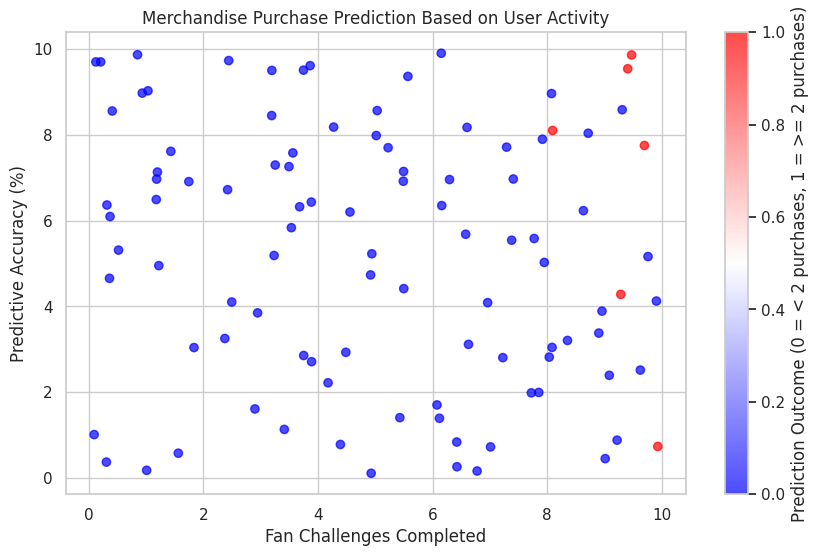

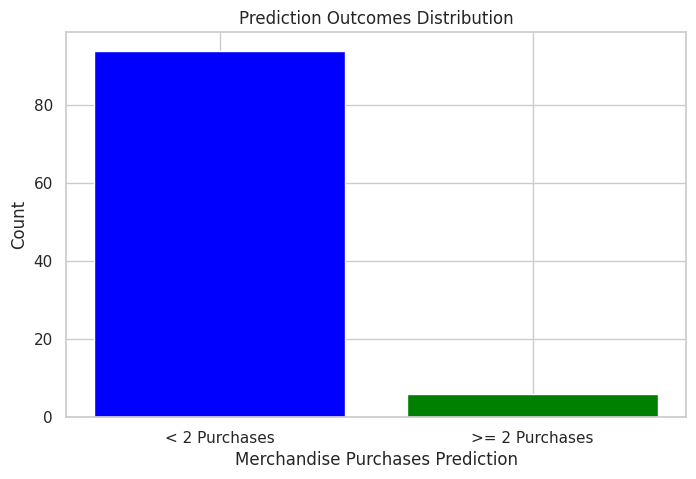

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load the logistic regression model and scaler
model = joblib.load('logistic_model.pkl')
scaler = joblib.load('scaler.pkl')

# Sample data generation for visualization (replace with your dataset if available)
# Creating 100 samples for visualization
np.random.seed(42)
sample_data = np.random.rand(100, 5) * 10  # Assuming feature values range between 0 to 10

# Feature names for the data
feature_names = [
    'Fan Challenges Completed',
    'Predictive Accuracy (%)',
    'Sponsorship Interactions (Ad Clicks)',
    'Time on Live 360 (mins)',
    'Real-Time Chat Activity (Messages Sent)'
]

# Scale and predict merchandise purchases using the logistic model
scaled_data = scaler.transform(sample_data)
predictions = model.predict(scaled_data)

# Visualization 1: Scatter plot of the first two features against prediction outcome
plt.figure(figsize=(10, 6))
plt.scatter(sample_data[:, 0], sample_data[:, 1], c=predictions, cmap='bwr', alpha=0.7)
plt.xlabel(feature_names[0])  # 'Fan Challenges Completed'
plt.ylabel(feature_names[1])  # 'Predictive Accuracy (%)'
plt.title('Merchandise Purchase Prediction Based on User Activity')
plt.colorbar(label='Prediction Outcome (0 = < 2 purchases, 1 = >= 2 purchases)')
plt.grid(True)
plt.show()

# Visualization 2: Bar chart of feature importance by prediction outcome
prediction_counts = np.bincount(predictions)
plt.figure(figsize=(8, 5))
plt.bar(['< 2 Purchases', '>= 2 Purchases'], prediction_counts, color=['blue', 'green'])
plt.title('Prediction Outcomes Distribution')
plt.xlabel('Merchandise Purchases Prediction')
plt.ylabel('Count')
plt.grid(True)
plt.show()


Corrleation between merchandise purchases and sponsorship interaction

  User ID  Fan Challenges Completed  Predictive Accuracy (%)  \
0    U001                         5                       80   
1    U002                         8                       60   
2    U003                         3                       90   
3    U004                         7                       70   
4    U005                         2                       50   

   Virtual Merchandise Purchases  Sponsorship Interactions (Ad Clicks)  \
0                              3                                    10   
1                              1                                     8   
2                              0                                     6   
3                              2                                    15   
4                              5                                     3   

   Time on Live 360 (mins)  Real-Time Chat Activity (Messages Sent)  
0                      120                                       20  
1                      100    

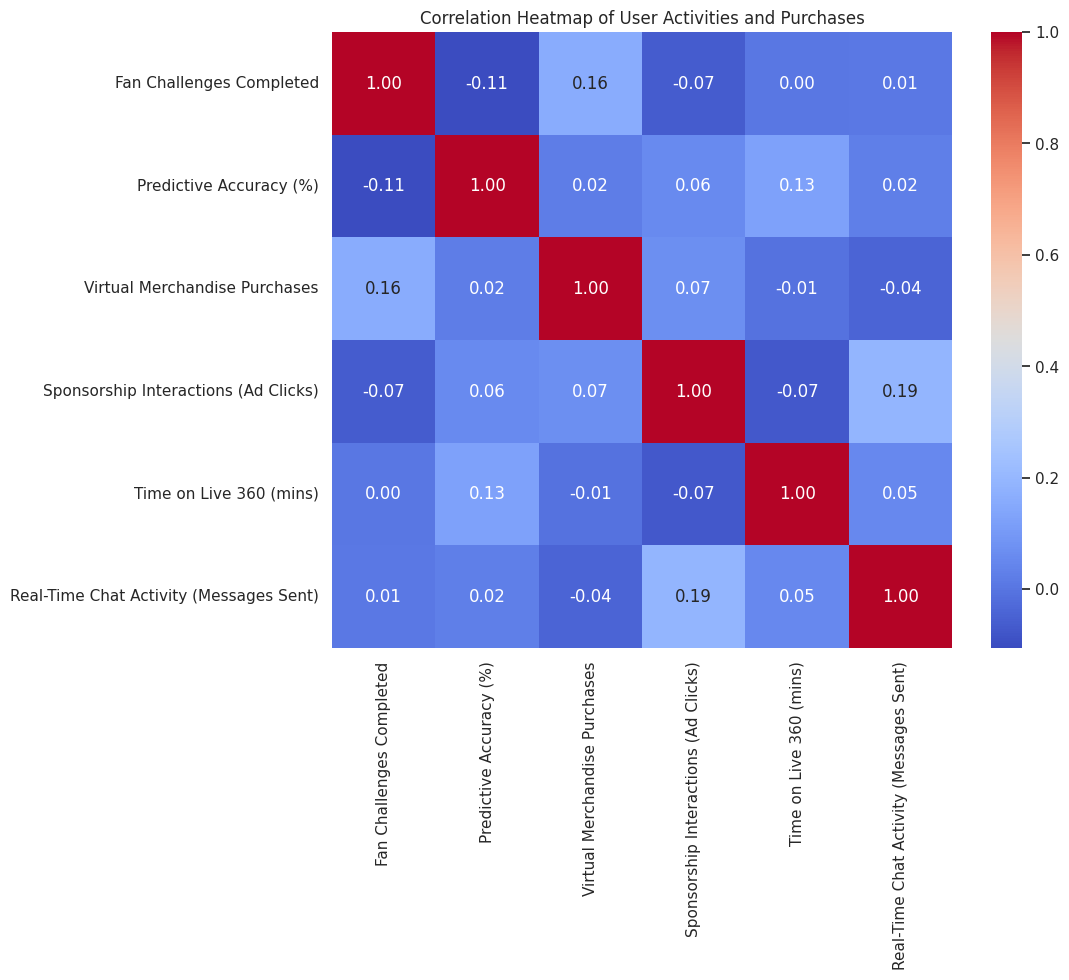

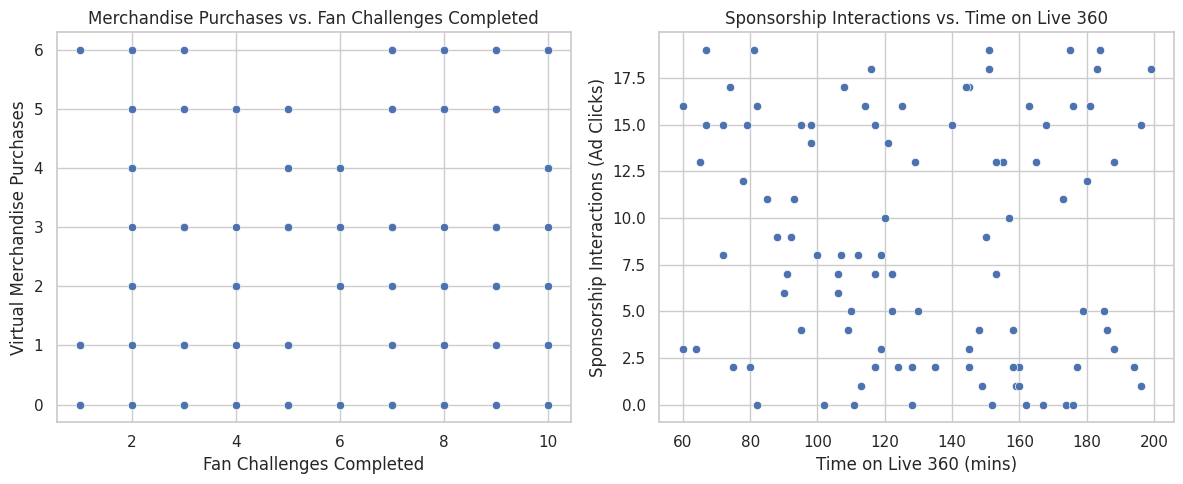

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('2025-VeloCityX-Expanded-Fan-Engagement-Data.csv') 

# Display the first few rows of the dataframe
print(df.head())

# Calculate the correlation matrix for relevant features
correlation_matrix = df[['Fan Challenges Completed', 
                          'Predictive Accuracy (%)', 
                          'Virtual Merchandise Purchases', 
                          'Sponsorship Interactions (Ad Clicks)', 
                          'Time on Live 360 (mins)', 
                          'Real-Time Chat Activity (Messages Sent)']].corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of User Activities and Purchases')
plt.show()

# Visualize specific correlations with scatter plots
plt.figure(figsize=(12, 5))

# Merchandise Purchases vs. Fan Challenges Completed
plt.subplot(1, 2, 1)
sns.scatterplot(data=df, x='Fan Challenges Completed', y='Virtual Merchandise Purchases')
plt.title('Merchandise Purchases vs. Fan Challenges Completed')
plt.xlabel('Fan Challenges Completed')
plt.ylabel('Virtual Merchandise Purchases')

# Sponsorship Interactions vs. Time on Live 360
plt.subplot(1, 2, 2)
sns.scatterplot(data=df, x='Time on Live 360 (mins)', y='Sponsorship Interactions (Ad Clicks)')
plt.title('Sponsorship Interactions vs. Time on Live 360')
plt.xlabel('Time on Live 360 (mins)')
plt.ylabel('Sponsorship Interactions (Ad Clicks)')

plt.tight_layout()
plt.show()


Real-time chat activity has the strongest correlation with sponsorship interactions (0.19), indicating that users who chat more are more likely to click on ads.
Fan challenges have a mild positive correlation with virtual merchandise purchases (0.16), suggesting that completing challenges slightly boosts merchandise sales.
Most other activities, like predictive accuracy and time on Live 360, show very weak correlations with both merchandise purchases and sponsorship interactions, implying these activities don't strongly drive buying behavior or ad engagement.